# Discourse Relation Classification with XLM-RoBERTa-Large (Natural Ordering)

Trains and evaluates `bxlm-roberta-large` on DISRPT 2025 Task 3 using **natural argument ordering**.  
All model layers are first frozen, then only the top X% of encoder layers are unfrozen for fine-tuning (0%, 25%, 50%, 75%, or 100%), allowing controlled experiments on partial unfreezing.


**Task Info:** https://sites.google.com/view/disrpt2025/  
**Project Repo:** https://github.com/CLaC-Lab/DISRPT-2025  

**Author:** Nawar Turk



# 1. Setup


## 1.1. Environment & Seeds

In [ ]:
import os
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from collections import Counter
import shutil  # for making the zip archive
from google.colab import files  # for downloading in Colab
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt
import random
import torch
from transformers import set_seed
from datasets import Dataset
from sklearn.metrics import classification_report

In [ ]:
SEED = 42

In [ ]:
def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    print(f"✅ Global seed set: {seed}")

set_global_seed(SEED)

✅ Global seed set: 42


## 1.2. Load Datasets

In [ ]:
# Load datasets from local or public paths
train_dataset = pd.read_csv('path/to/train_dataset.csv')
dev_dataset = pd.read_csv('path/to/dev_dataset.csv')

# 2. Helper Functions

## 2.1. Plotting Function

In [ ]:
def plot_metrics_per_epoch(trainer):
    """Plot training loss, validation loss, and accuracy per epoch from a Trainer's log history."""

    log_history = trainer.state.log_history

    train_losses = []
    val_losses = []
    val_accuracies = []
    epochs = []

    for entry in log_history:
        if 'eval_loss' in entry:
            epoch = entry.get('epoch')
            eval_loss = entry['eval_loss']
            val_acc = entry.get('eval_accuracy')

            # Look for the training loss in the same or previous entry
            train_loss = None
            for e in reversed(log_history[:log_history.index(entry)+1]):
                if 'loss' in e and e.get('epoch') == epoch:
                    train_loss = e['loss']
                    break

            if epoch is not None and train_loss is not None:
                epochs.append(epoch)
                train_losses.append(train_loss)
                val_losses.append(eval_loss)
                val_accuracies.append(val_acc)

    # Plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    ax1.plot(epochs, val_losses, label="Val Loss", color="orange", marker='x')
    ax1.set_xticks(range(1, len(epochs) + 1))
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylim(0.0, 1.0)
    ax2.plot(epochs, val_accuracies, label="Val Accuracy", color="green", marker='s')
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="upper right")

    # Find best epoch and accuracy
    best_idx = val_accuracies.index(max(val_accuracies))
    best_epoch = epochs[best_idx]
    best_acc = val_accuracies[best_idx]
    # Plot marker and label
    ax2.plot(best_epoch, best_acc, 'ro')  # red dot
    ax2.text(best_epoch, best_acc + 0.02, f'{best_acc:.2f}', color='red', ha='center')

    plt.title("Training vs Validation Loss and Accuracy per Epoch")
    plt.tight_layout()
    plt.show()

## 2.2. Training Function

In [ ]:

def train(model_name, train, dev, arg1_key, arg2_key, unfreeze_ratio):
  """
  Fine-tunes a transformer model for discourse relation classification with controlled layer freezing.

  This function:
  1. Converts train and dev datasets into DataFrames and encodes labels.
  2. Tokenizes text pairs (Arg1, Arg2) using the specified tokenizer.
  3. Loads a pretrained transformer for sequence classification.
  4. Freezes embeddings and a portion of encoder layers according to `unfreeze_ratio`.
  5. Trains the model with evaluation, early stopping, and metric tracking (accuracy, macro/micro F1).
  6. Saves:
    - Predictions with labels
    - Confusion matrix
    - Evaluation metrics
    - Fine-tuned model and tokenizer
  7. Prints:
    - Layer freezing summary
    - Accuracy/F1 scores overall, by language, and by framework
    - Classification report

  Args:
      model_name (str): Hugging Face model identifier.
      train (pd.DataFrame or list of dict): Training data with Arg1, Arg2, and label_text.
      dev (pd.DataFrame or list of dict): Development/validation data.
      arg1_key (str): Column name for the first argument text.
      arg2_key (str): Column name for the second argument text.
      unfreeze_ratio (float): Proportion of encoder layers to unfreeze (0.0 = all frozen, 1.0 = all unfrozen).

  Returns:
      tuple: (trainer, dev_with_predictions DataFrame)
  """

  # prepare_datasets_for_training
  train_df = pd.DataFrame(train)
  dev_df = pd.DataFrame(dev)

  unique_labels = sorted(train_df['label_text'].unique())
  label2id = {label: i for i, label in enumerate(unique_labels)}
  id2label = {i: label for i, label in enumerate(unique_labels)}

  train_df['label'] = train_df['label_text'].map(label2id)
  dev_df['label'] = dev_df['label_text'].map(label2id)

  # Tokenization function
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  def tokenize(examples):
    return tokenizer(
        examples[arg1_key],
        examples[arg2_key],
        truncation=True,
        padding=True,
        max_length=512
        )
  train_dataset = Dataset.from_pandas(train_df)
  dev_dataset = Dataset.from_pandas(dev_df)
  train_dataset = train_dataset.map(tokenize, batched=True)
  dev_dataset = dev_dataset.map(tokenize, batched=True)

  # Load a model
  model = AutoModelForSequenceClassification.from_pretrained(
  model_name,
  num_labels=len(unique_labels),
  id2label=id2label,
  label2id=label2id
  )

  output_dir = f"./{model_name.replace('/', '-')}-discourse-OD-{arg1_key}"

  # Freeze embeddings always
  if hasattr(model.base_model, 'embeddings'):
    for param in model.base_model.embeddings.parameters():
      param.requires_grad = False
  else:
    print("⚠️ Could not apply embedding freezing. Unexpected model structure.")

  # Freeze encoder layers based on unfreeze_ratio
  if hasattr(model.base_model, 'encoder') and hasattr(model.base_model.encoder, 'layer'):
    total_layers = len(model.base_model.encoder.layer)
    unfreeze_start = int((1 - unfreeze_ratio) * total_layers)

    for i, layer in enumerate(model.base_model.encoder.layer):
      requires_grad = i >= unfreeze_start
      for param in layer.parameters():
        param.requires_grad = requires_grad

    print(f"*_Total encoder layers: {total_layers}")
    if unfreeze_ratio > 0:
      print(f"*_Unfreezing from layer {unfreeze_start} to {total_layers - 1}")
    else:
      print("*_All layers frozen")
  else:
    print("⚠️ Could not apply encoder layer freezing. Unexpected model structure.")

  def print_trainable_parameters(model):
    from collections import defaultdict
    grouped = defaultdict(list)

    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"*_Total parameters:     {total:,}")
    print(f"*__Trainable parameters: {trainable:,}")
    print(f"*__Trainable ratio:      {100 * trainable / total:.2f}%")

    for name, param in model.named_parameters():
      if param.requires_grad:
        # top_group = '.'.join(name.split('.')[:4]) if 'bert.encoder.layer' in name else '.'.join(name.split('.')[:2])
        if 'roberta.encoder.layer' in name or 'bert.encoder.layer' in name or 'deberta.encoder.layer' in name:
          top_group = '.'.join(name.split('.')[:4])  # up to the layer index
        else:
          top_group = '.'.join(name.split('.')[:2])
        grouped[top_group].append(name)

    for group, names in sorted(grouped.items()):
      print(f"✅ {group}: ({len(names)} params)")

  print_trainable_parameters(model)

  training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=20,
    weight_decay=0.01,
    warmup_ratio=0.1,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=3,
    seed=SEED,
    data_seed=SEED,
    dataloader_num_workers=0,  # deterministic
    fp16=True
    )

  def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    return {"accuracy": accuracy, "f1_macro": f1_macro, "f1_micro": f1_micro}

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=dev_dataset,
      processing_class=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  )

  trainer.train()

  predictions = trainer.predict(dev_dataset)
  preds = np.argmax(predictions.predictions, axis=-1)

  # Convert to DataFrame and add predictions
  dev_with_predictions = dev_dataset.to_pandas().reset_index(drop=True)
  dev_with_predictions['pred_label_id'] = preds
  dev_with_predictions['pred_label'] = dev_with_predictions['pred_label_id'].map(id2label)

  # Create confusion matrix
  confusion_matrix = pd.crosstab(
      dev_with_predictions['label_text'],
      dev_with_predictions['pred_label'],
      margins=False  # No totals for averaging
  )

  # Save as CSV
  filename = f"confusion_matrix_{arg1_key}{model_name.replace('/','-')}-{unfreeze_ratio}.csv"
  confusion_matrix.to_csv(filename)
  print(f"Saved: {filename}")

  true_labels = dev_with_predictions['label_text'].values
  pred_labels = dev_with_predictions['pred_label'].values

  # Save CSV
  predictions_file = f"predictions_{model_name.replace('/','-')}_{arg1_key}-{unfreeze_ratio}.csv"
  dev_with_predictions.to_csv(predictions_file, index=False)
  print(f"💾 Saved predictions to: {predictions_file}")

  # Calculate comprehensive metrics using sklearn
  accuracy = accuracy_score(true_labels, pred_labels)
  f1_macro = f1_score(true_labels, pred_labels, average='macro')
  f1_micro = f1_score(true_labels, pred_labels, average='micro')
  f1_weighted = f1_score(true_labels, pred_labels, average='weighted')

  print(f"📊 {model_name.upper()} on DEV RESULTS:")
  print(f"   Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
  print(f"   F1-Macro:    {f1_macro:.4f}")
  print(f"   F1-Micro:    {f1_micro:.4f}")
  print(f"   F1-Weighted: {f1_weighted:.4f}")

  # Optional: Print detailed classification report
  if len(id2label) <= 20:
      print(f"\n📋 Classification Report:")
      target_names = [id2label[i] for i in sorted(id2label.keys())]
      print(classification_report(true_labels, pred_labels,
                                target_names=target_names,
                                digits=4, zero_division=0))

  def lang_accuracy(data):
   languages = data['lang'].unique()
   for lang in languages:
       lang_data = data[data['lang']==lang]
       lang_acc = (lang_data['label_text'] == lang_data['pred_label']).mean().round(3)
       print(f"{lang}: {lang_acc*100:.1f}%")

  def framework_accuracy(data):
    frameworks = data['framework'].unique()
    for fw in frameworks:
        fw_data = data[data['framework']==fw]
        fw_acc = (fw_data['label_text'] == fw_data['pred_label']).mean().round(3)
        print(f"{fw}: {fw_acc*100:.1f}%")

  lang_accuracy(dev_with_predictions)
  framework_accuracy(dev_with_predictions)

  # Save Model
  save_path = f"./{model_name.replace('/', '-')}-discourse-final-{arg1_key}-{unfreeze_ratio}"
  trainer.save_model(save_path)
  trainer.tokenizer.save_pretrained(save_path)
  zip_path = shutil.make_archive(save_path, 'zip', save_path)

  return trainer, dev_with_predictions

# 3. Experiments

In [ ]:
model_name = "xlm-roberta-large"
arg1_key = 'unordered_arg1'
arg2_key = 'unordered_arg2'

## 3.1. Unfreeze 0%

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*_Total encoder layers: 24
*_All layers frozen
*_Total parameters:     559,907,857
*__Trainable parameters: 1,067,025
*__Trainable ratio:      0.19%
✅ classifier.dense: (2 params)
✅ classifier.out_proj: (2 params)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,2.528100,2.417632,0.252811,0.042375,0.252811
2,2.370400,2.336086,0.287673,0.082377,0.287673
3,2.297000,2.280229,0.296162,0.087444,0.296162
4,2.257300,2.246152,0.298411,0.089058,0.298411
5,2.232300,2.220881,0.305195,0.097207,0.305195
6,2.215700,2.201178,0.305340,0.097856,0.305340
7,2.202500,2.185779,0.306827,0.096405,0.306827
8,2.194700,2.175688,0.313901,0.103710,0.313901
9,2.188600,2.168475,0.316658,0.106411,0.316658
10,2.181600,2.155370,0.314590,0.105355,0.314590


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,2.528100,2.417632,0.252811,0.042375,0.252811
2,2.370400,2.336086,0.287673,0.082377,0.287673
3,2.297000,2.280229,0.296162,0.087444,0.296162
4,2.257300,2.246152,0.298411,0.089058,0.298411
5,2.232300,2.220881,0.305195,0.097207,0.305195
6,2.215700,2.201178,0.305340,0.097856,0.305340
7,2.202500,2.185779,0.306827,0.096405,0.306827
8,2.194700,2.175688,0.313901,0.103710,0.313901
9,2.188600,2.168475,0.316658,0.106411,0.316658
10,2.181600,2.155370,0.314590,0.105355,0.314590


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Saved: confusion_matrix_unordered_arg1xlm-roberta-large-0.csv
💾 Saved predictions to: predictions_xlm-roberta-large_unordered_arg1-0.csv
📊 XLM-ROBERTA-LARGE on DEV RESULTS:
   Accuracy:    0.3219 (32.19%)
   F1-Macro:    0.1145
   F1-Micro:    0.3219
   F1-Weighted: 0.2346

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.0000    0.0000    0.0000       194
  attribution     0.7451    0.0429    0.0811       886
       causal     0.4414    0.2562    0.3242      2924
      comment     0.1000    0.0011    0.0022       920
   concession     0.2941    0.0155    0.0294      1294
    condition     0.0000    0.0000    0.0000       738
  conjunction     0.2533    0.3148    0.2807      4555
     contrast     0.8000    0.0032    0.0064      1254
  elaboration     0.3092    0.8210    0.4492      6412
  explanation     0.0000    0.0000    0.0000      1061
        frame     0.0000    0.0000    0.0000       797
         mode     0.0000    0.0000    0

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


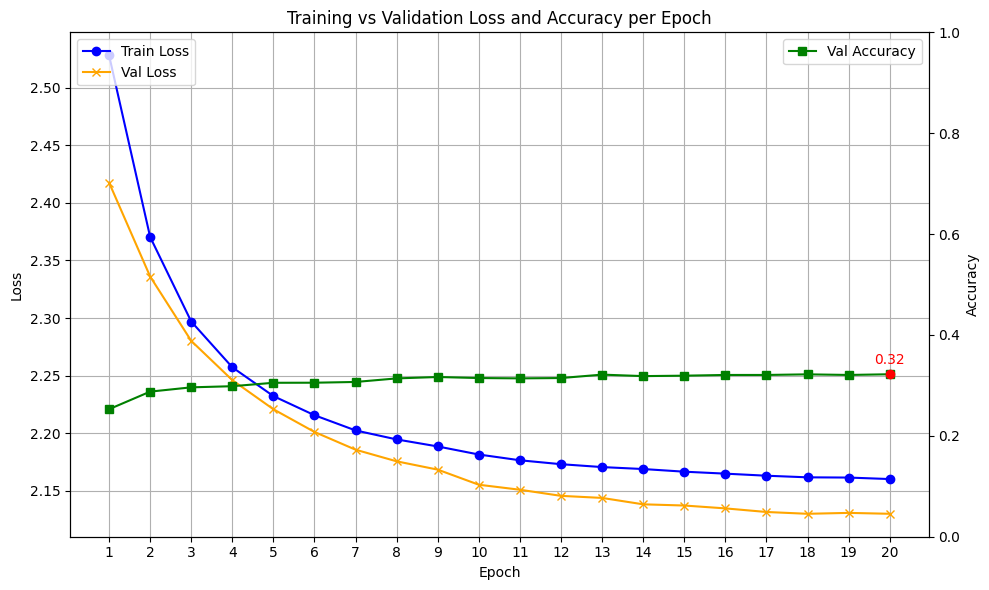

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key, unfreeze_ratio=0)
plot_metrics_per_epoch(trainer)

## 3.2. Unfreeze Top 25%

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*_Total encoder layers: 24
*_Unfreezing from layer 18 to 23
*_Total parameters:     559,907,857
*__Trainable parameters: 76,644,369
*__Trainable ratio:      13.69%
✅ classifier.dense: (2 params)
✅ classifier.out_proj: (2 params)
✅ roberta.encoder.layer.18: (16 params)
✅ roberta.encoder.layer.19: (16 params)
✅ roberta.encoder.layer.20: (16 params)
✅ roberta.encoder.layer.21: (16 params)
✅ roberta.encoder.layer.22: (16 params)
✅ roberta.encoder.layer.23: (16 params)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.766200,1.233708,0.608032,0.564229,0.608032
2,1.185200,1.142331,0.635130,0.607620,0.635130
3,1.055500,1.083486,0.650439,0.630421,0.650439
4,0.934800,1.074816,0.658819,0.639753,0.658819
5,0.826700,1.119213,0.655481,0.636532,0.655481
6,0.721000,1.178493,0.651636,0.632057,0.651636
7,0.618300,1.273695,0.648516,0.631184,0.648516


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

Saved: confusion_matrix_unordered_arg1xlm-roberta-large-0.25.csv
💾 Saved predictions to: predictions_xlm-roberta-large_unordered_arg1-0.25.csv
📊 XLM-ROBERTA-LARGE on DEV RESULTS:
   Accuracy:    0.6588 (65.88%)
   F1-Macro:    0.6398
   F1-Micro:    0.6588
   F1-Weighted: 0.6560

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.6617    0.6856    0.6734       194
  attribution     0.8856    0.9176    0.9013       886
       causal     0.6726    0.6618    0.6671      2924
      comment     0.5408    0.4391    0.4847       920
   concession     0.7052    0.6175    0.6584      1294
    condition     0.7314    0.7602    0.7455       738
  conjunction     0.5632    0.6962    0.6227      4555
     contrast     0.6202    0.5327    0.5731      1254
  elaboration     0.6821    0.6842    0.6831      6412
  explanation     0.3925    0.3770    0.3846      1061
        frame     0.7584    0.3664    0.4941       797
         mode     0.6187    0.635

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


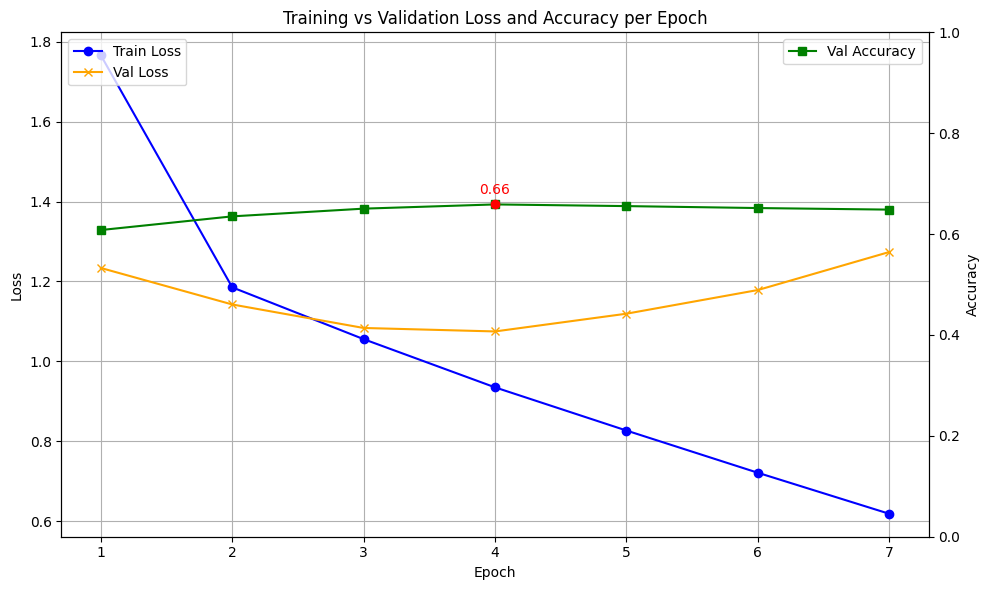

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key, unfreeze_ratio=0.25)
plot_metrics_per_epoch(trainer)



---



## 3.3. Unfreeze Top 50%

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*_Total encoder layers: 24
*_Unfreezing from layer 12 to 23
*_Total parameters:     559,907,857
*__Trainable parameters: 152,221,713
*__Trainable ratio:      27.19%
✅ classifier.dense: (2 params)
✅ classifier.out_proj: (2 params)
✅ roberta.encoder.layer.12: (16 params)
✅ roberta.encoder.layer.13: (16 params)
✅ roberta.encoder.layer.14: (16 params)
✅ roberta.encoder.layer.15: (16 params)
✅ roberta.encoder.layer.16: (16 params)
✅ roberta.encoder.layer.17: (16 params)
✅ roberta.encoder.layer.18: (16 params)
✅ roberta.encoder.layer.19: (16 params)
✅ roberta.encoder.layer.20: (16 params)
✅ roberta.encoder.layer.21: (16 params)
✅ roberta.encoder.layer.22: (16 params)
✅ roberta.encoder.layer.23: (16 params)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.617500,1.133432,0.635566,0.599934,0.635566
2,1.078200,1.101903,0.653668,0.627411,0.653668
3,0.936600,1.049021,0.665276,0.645578,0.665276
4,0.776900,1.094342,0.664950,0.644178,0.664950
5,0.633000,1.180637,0.665240,0.644476,0.665240
6,0.505300,1.289752,0.662846,0.643718,0.662846


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

Saved: confusion_matrix_unordered_arg1xlm-roberta-large-0.5.csv
💾 Saved predictions to: predictions_xlm-roberta-large_unordered_arg1-0.5.csv
📊 XLM-ROBERTA-LARGE on DEV RESULTS:
   Accuracy:    0.6653 (66.53%)
   F1-Macro:    0.6456
   F1-Micro:    0.6653
   F1-Weighted: 0.6625

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.8855    0.5979    0.7138       194
  attribution     0.9136    0.9074    0.9105       886
       causal     0.6357    0.6939    0.6635      2924
      comment     0.5575    0.4217    0.4802       920
   concession     0.5684    0.6971    0.6262      1294
    condition     0.8393    0.6938    0.7596       738
  conjunction     0.6566    0.6531    0.6549      4555
     contrast     0.5727    0.5247    0.5476      1254
  elaboration     0.6807    0.7054    0.6928      6412
  explanation     0.4608    0.3384    0.3902      1061
        frame     0.5705    0.4467    0.5011       797
         mode     0.6557    0.6266 

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


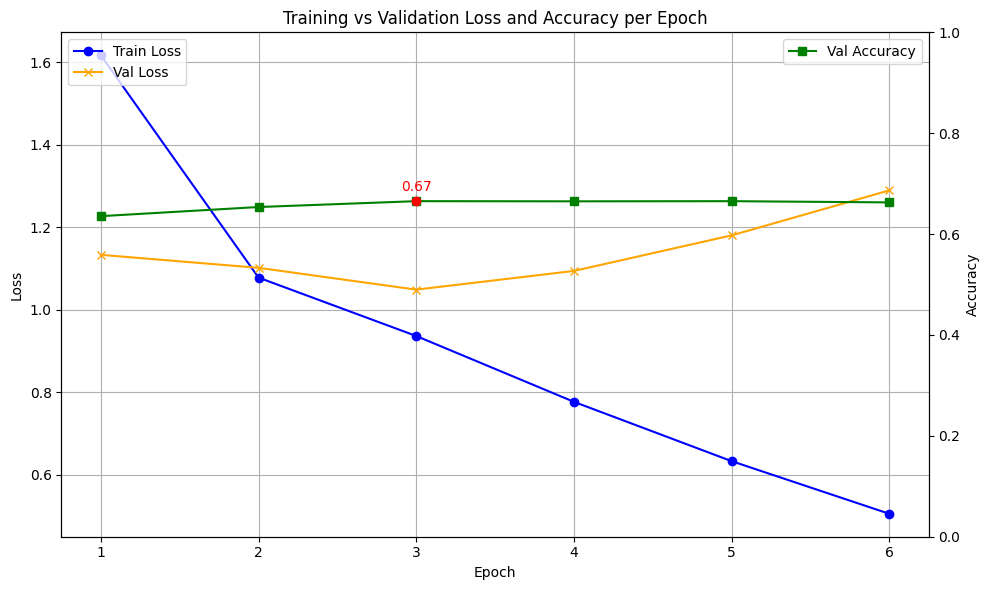

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key, unfreeze_ratio=0.5)
plot_metrics_per_epoch(trainer)

## 3.4. Unfreeze Top 75%

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*_Total encoder layers: 24
*_Unfreezing from layer 6 to 23
*_Total parameters:     559,907,857
*__Trainable parameters: 227,799,057
*__Trainable ratio:      40.69%
✅ classifier.dense: (2 params)
✅ classifier.out_proj: (2 params)
✅ roberta.encoder.layer.10: (16 params)
✅ roberta.encoder.layer.11: (16 params)
✅ roberta.encoder.layer.12: (16 params)
✅ roberta.encoder.layer.13: (16 params)
✅ roberta.encoder.layer.14: (16 params)
✅ roberta.encoder.layer.15: (16 params)
✅ roberta.encoder.layer.16: (16 params)
✅ roberta.encoder.layer.17: (16 params)
✅ roberta.encoder.layer.18: (16 params)
✅ roberta.encoder.layer.19: (16 params)
✅ roberta.encoder.layer.20: (16 params)
✅ roberta.encoder.layer.21: (16 params)
✅ roberta.encoder.layer.22: (16 params)
✅ roberta.encoder.layer.23: (16 params)
✅ roberta.encoder.layer.6: (16 params)
✅ roberta.encoder.layer.7: (16 params)
✅ roberta.encoder.layer.8: (16 params)
✅ roberta.encoder.layer.9: (16 params)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.614600,1.111093,0.644744,0.608675,0.644744
2,1.063600,1.111441,0.656896,0.634220,0.656896
3,0.938300,1.044960,0.667598,0.641901,0.667598
4,0.776900,1.095807,0.667054,0.647761,0.667054
5,0.631200,1.182903,0.664659,0.646791,0.664659
6,0.500000,1.300633,0.659000,0.642617,0.659000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

Saved: confusion_matrix_unordered_arg1xlm-roberta-large-0.75.csv
💾 Saved predictions to: predictions_xlm-roberta-large_unordered_arg1-0.75.csv
📊 XLM-ROBERTA-LARGE on DEV RESULTS:
   Accuracy:    0.6676 (66.76%)
   F1-Macro:    0.6419
   F1-Micro:    0.6676
   F1-Weighted: 0.6639

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.7786    0.5619    0.6527       194
  attribution     0.8991    0.9255    0.9121       886
       causal     0.6353    0.7001    0.6661      2924
      comment     0.5475    0.4326    0.4833       920
   concession     0.5773    0.6893    0.6284      1294
    condition     0.8097    0.7209    0.7627       738
  conjunction     0.6307    0.6696    0.6496      4555
     contrast     0.6068    0.5144    0.5568      1254
  elaboration     0.6946    0.7088    0.7017      6412
  explanation     0.4691    0.3148    0.3768      1061
        frame     0.5402    0.4304    0.4791       797
         mode     0.6778    0.598

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


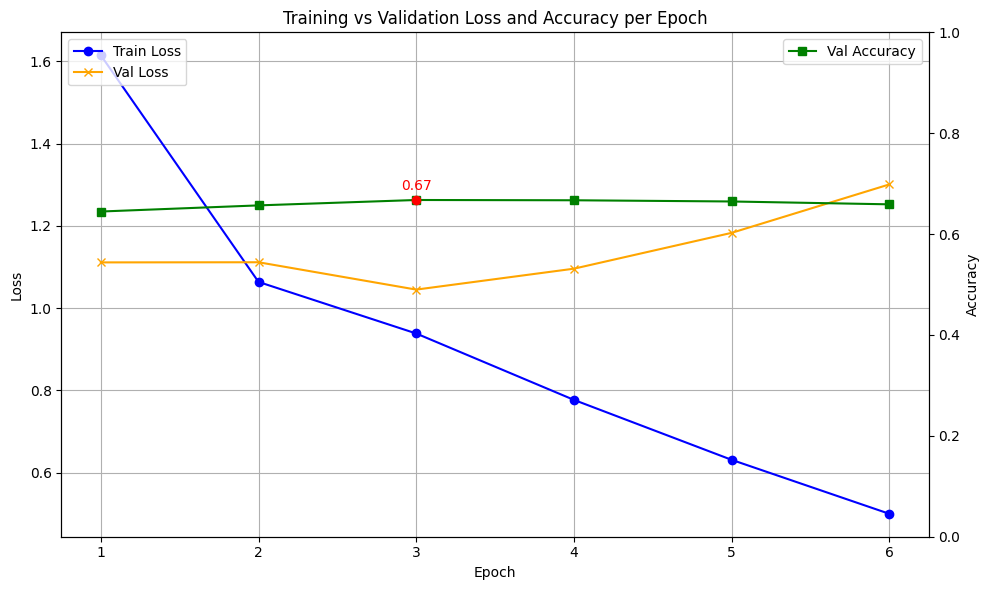

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key, unfreeze_ratio=0.75)
plot_metrics_per_epoch(trainer)